# Introduction:



In [4]:
library(tidyverse)
library(janitor)
download.file(url= "https://raw.githubusercontent.com/chl0ehuang/Project-003-15/refs/heads/main/players.csv", destfile = "players.csv")

players_data <- read_csv("players.csv")
head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Broad Question:
Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### Specfic Question: 
Can the experience of level of players, total hours played by player, and the age of players help predict whether or not they will subscribe to a PLAICraft newsletter in the players.csv dataset?”

### Information About Variables

Variables/predictors for the K-NN classification model predict whether or not a player will subscribe to a PLAICraft newsletter:
- Experience Level of Player (character in players.csv, but is changed to factor): `experience`
- Total Hours of Player (double): `played_hours`
- Age of Player (double): `age`

Variables that will not be used as a predicitor in the model:
- Gender of Player (character):`gender` since the K-NN model calculates distances of the nearest neighbors to the unknown observation, gender includes descrete categories. While categorical variables could be converted to numeric values, this is not appropriate as there is no meaningful numeric relationship between categories such as Male and Female.
- Hashed Email of Players (character):`hashedEmail` it does not give us charteristic information about the players.
- Name of the Player (character): `name` it does not give us charteristic information about the players. 

Response variable in model:
- Whether or not the user subscribes to the newsletter (logical in players.csv, but is changed to factor): `subscribe`.

### Tidying and Organizing the Data: 
The columns `hashedEmail`, `name` , and `gender` is removed as it is not relevant to our classsification model. The `Age` column is also renamed with lowercases allowing consistency between column names. Additionally, since the observations in `subscribe` are categories, the column type is changed to factor.

After wrangling and tidying the data in the `players` object data frame, the data appears data as each variable forms a column, each observation forms a row, and each cell is a single measurment.

In [5]:
#Tidying and organizing the data
players <- players_data |>
    select(-hashedEmail, -name, -gender) |> 
    rename(age = Age)|>
    mutate(subscribe = as_factor(subscribe)) |>     
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE")) 

head(players)

experience,subscribe,played_hours,age
<chr>,<fct>,<dbl>,<dbl>
Pro,Yes,30.3,9
Veteran,Yes,3.8,17
Veteran,No,0.0,17
Amateur,Yes,0.7,21
Regular,Yes,0.1,21
Amateur,Yes,0.0,17


# Exploratory Data Analysis, Visualization, and Summary Statistics
### Dataset Summary Statistics

In [6]:
#Total Number of Players and Percent of Players that Subscribe To The Newsletter
yes_subscribe <- players |>
    filter(subscribe == "Yes")|>
    summarize(yes_subscribe_count = n())

yes_no_subscribe <- players_data |>
    summarize(total_num_of_players = n())|>
    bind_cols(yes_subscribe) |>
    mutate(percentage_total_of_yes_subscribe = (yes_subscribe_count/total_num_of_players)*100) |>
    round(digits = 2)|>
    select(-yes_subscribe_count)
yes_no_subscribe

#Mean, Minimum, and Maximum Age of Players in Data Set
mean_age <- players_data |>
    rename(age = Age)|>
    summarize(mean_age_of_players = mean(age, na.rm=TRUE), min_age = min(age, na.rm=TRUE), max_age = max(age, na.rm=TRUE))|>
    round(digits = 2)
mean_age

#Mean, Minimum, and Maximum Hours Played
mean_hours <- players_data |>
    summarize(mean_hours_played = mean(played_hours), min_hours = min(played_hours), max_hours = max(played_hours)) |>
    round(digits = 2)
mean_hours

#Total Number of Players For Each Experience Level
experience_level <- players_data |>
    group_by(experience)|>
    summarize(num_of_players = n())
experience_level

#Total Number of Players For Each Gender Identity
gender <- players_data |>
    group_by(gender)|>
    summarize(num_of_players = n())
gender

total_num_of_players,percentage_total_of_yes_subscribe
<dbl>,<dbl>
196,73.47


mean_age_of_players,min_age,max_age
<dbl>,<dbl>,<dbl>
21.14,9,58


mean_hours_played,min_hours,max_hours
<dbl>,<dbl>,<dbl>
5.85,0,223.1


experience,num_of_players
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


gender,num_of_players
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


### Dataset Summary Statistics
The predictors of the K-NN classification model are plotted in graphs:

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


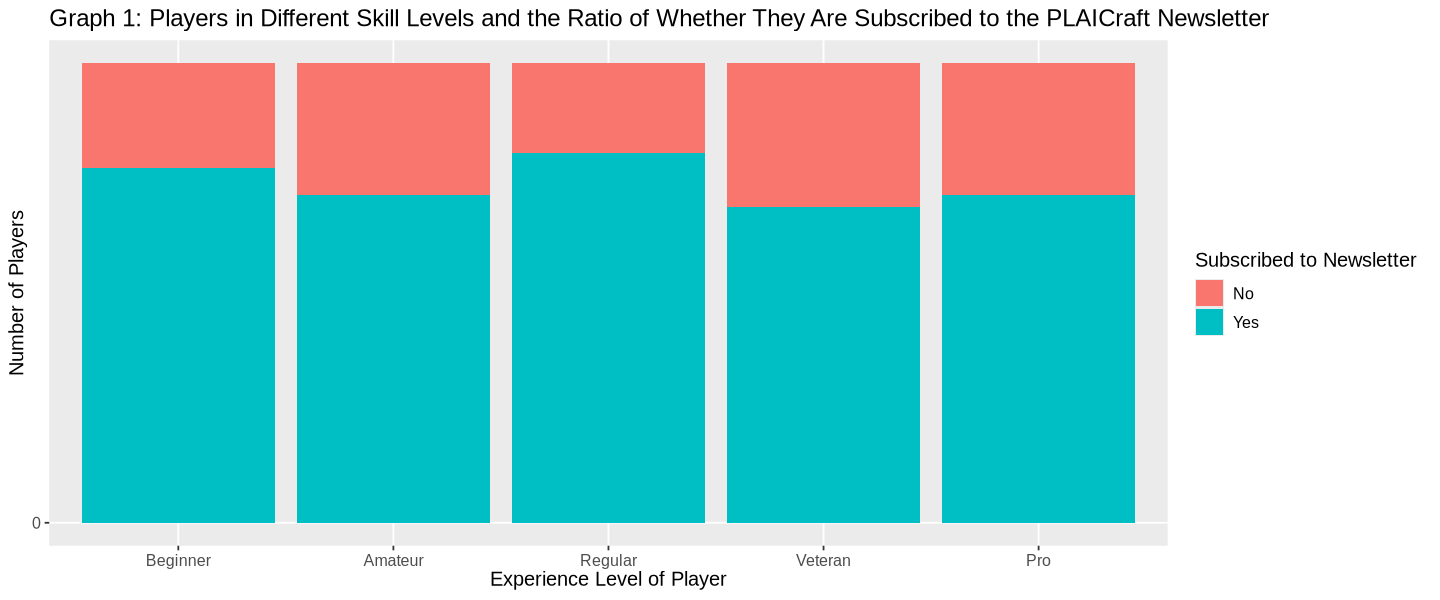

In [7]:
options(repr.plot.width = 12, repr.plot.height = 5)

#Graph 1: Players in Different Experience Levels and the Ratio of Whether They Are Subscribed to the PLAICraft Newsletter
experience_distribution <- players |>
    group_by(experience, subscribe)|>
    summarize(number_of_players = n()) |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))) |>
    ggplot(aes(x = experience, y = number_of_players, fill = subscribe)) +
    geom_bar(stat= "identity",position = "fill") +
    labs(x = "Experience Level of Player", y = "Number of Players", fill = "Subscribed to Newsletter") +
    ggtitle("Graph 1: Players in Different Skill Levels and the Ratio of Whether They Are Subscribed to the PLAICraft Newsletter") +
    theme(text = element_text(size = 12)) +
    scale_y_continuous(breaks = seq(from = 0, to = 250, by = 10))
experience_distribution

It apppears that those with Regular experience are most likely to sign up for the newsletter, while Veterans are the least likely to.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


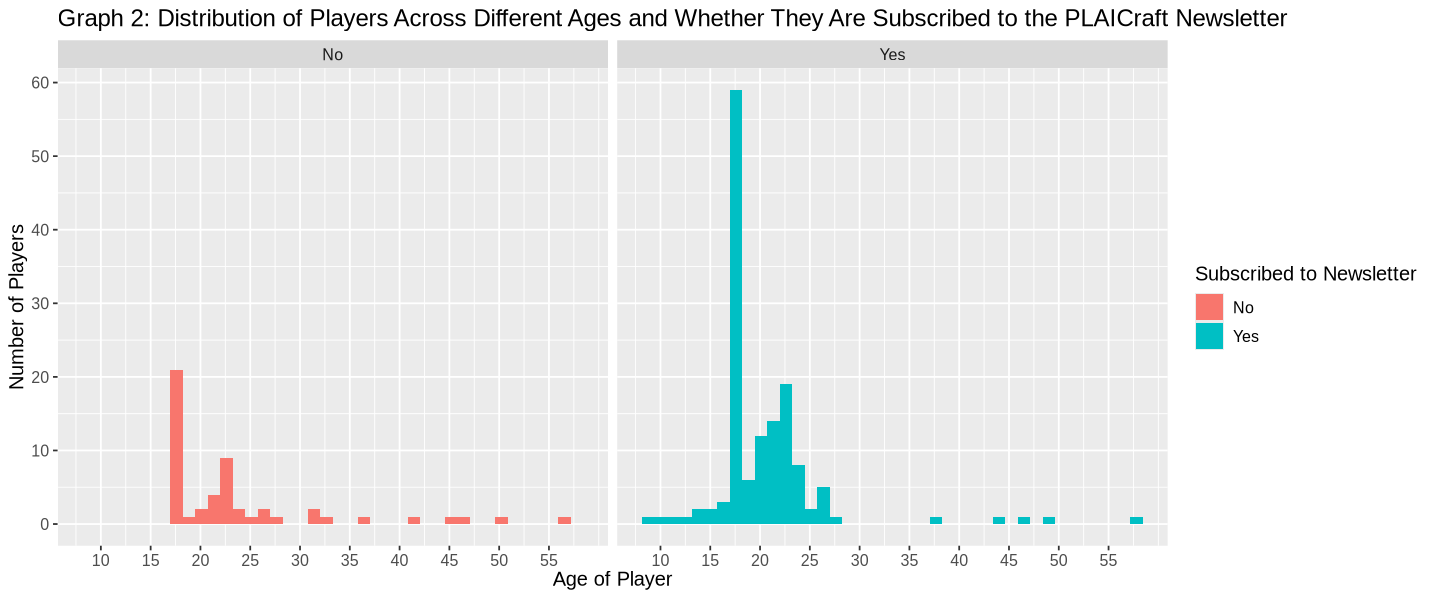

In [8]:
#Graph 2: Distribution of Players Across Different Ages and Whether They Are Subscribed to the PLAICraft Newsletter
age_disribution <- players |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(bins=40) +
    facet_grid(cols = vars(subscribe)) +
    labs(x = "Age of Player", y = "Number of Players", fill = "Subscribed to Newsletter") +
    ggtitle("Graph 2: Distribution of Players Across Different Ages and Whether They Are Subscribed to the PLAICraft Newsletter") +
    theme(text = element_text(size = 12)) +
    scale_x_continuous(breaks = seq(from = 10, to = 57, by = 5)) +
    scale_y_continuous(breaks = seq(from = 0, to = 80, by = 10))
age_disribution

By looking at the graphs, the mean age of player of those who sign up for the newsletter are younger than the mean age of those who do not.

In [ ]:
#Graph 3: Distribution of Players With Different Played Hours and Whether They Are Subscribed to the PLAICraft Newsletter
hours_disribution <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins=10) +
    facet_grid(cols = vars(subscribe)) +
    labs(x = "Hours Played", y = "Number of Players", fill = "Subscribed to Newsletter") +
    ggtitle("Graph 3: Distribution of Players With Different Played Hoursand Whether They Are Subscribed to the PLAICraft Newsletter") +
    theme(text = element_text(size = 12)) +
    scale_x_continuous(breaks = seq(from = 0, to = 240, by = 20)) +
    scale_y_continuous(breaks = seq(from = 0, to = 250, by = 20))
hours_disribution

The graph shows that those who play more hours are more likey to sign up for the newsletter while those who play less hours are less likey to.

In [ ]:
# 4. Methods and Plan
The variables `experience`, `played_hours`, and `age` will serve as predictors in a K-NN classification model to predict `subscribe`, indicating whether a PLAICraft user will subscribe to the newsletter. This is an appropriate method as predicting whether or not a player will subscribe can be assigned as a class. A 70/30 split of training/testing will be used due to the small dataset, along with a 5-fold cross-validation to determine the appropriate k-value. 

### Limitations and Weaknesses
- Some players recorded 0 played hours, which could be inaccurate. For example, a Pro has would have needed more playtime to reach that level (row 12). As a result, this dataset may not accurately reflect information about PLAICraft users. 
- Some players' age were recorded as NA. This could have reduced accuracy since not all observations in players.csv were accounted for in age-related calculations.

### Assumptions of the Model
To apply these predictors, `experience` must be converted to numeric values 1-5 to allow for distance calculations. 